In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sbn
import pathlib as pal
from scipy import io as sio
from matplotlib import pyplot as plt

In [3]:
root_p = pal.Path('/home/surchs/data/')
glm_p = root_p / 'paper_16p22q/glm/22q/cambridge64/del_minus_con/glm_del_minus_con_cambridge64.mat'
labels_p = root_p / 'ATLAS/MIST/Parcel_Information/MIST_64.csv'
labels7_p = root_p / 'ATLAS/MIST/Parcel_Information/MIST_64.csv'
labels12_p = root_p / 'ATLAS/MIST/Parcel_Information/MIST_64.csv'
hier_p = root_p / 'ATLAS/MIST/Hierarchy/MIST_PARCEL_ORDER.csv'
temp_p = root_p / 'ATLAS/MIST/Parcellations/MIST_64.nii.gz'
fig_p = root_p /  'paper_16p22q/figures/unclear/'

In [4]:
def octvec2mat(vec, mask):
    """
    Takes a vector in Fortran style (Octave/Matlab)
    and maps it back into a mask correctly in 
    python
    """
    vec_mat = mask.flatten(order='F').astype(bool)
    tmp = np.zeros_like(vec_mat, dtype=float)
    tmp[vec_mat] = vec
    vol = np.reshape(tmp, mask.shape, order='F')
    return vol

In [5]:
def oct2mat(vec, mask):
    temp = octvec2mat(vec, mask)
    temp += temp.T
    # Reset diagonal
    temp[np.eye(mask.shape[0]).astype(bool)] = temp[np.eye(mask.shape[0]).astype(bool)]/2
    return temp

In [6]:
tmp = sio.loadmat(glm_p)
# Get the FDR
fdr = tmp['fdr']
eff = tmp['eff']
# Get to Matrix format
eff_mat = oct2mat(eff.squeeze(), np.tril(np.ones((64,64))).astype(bool))
eff_vec_full = eff_mat[np.tril(np.ones((64,64))).astype(bool)]

fdr_vec = fdr[np.tril(np.ones((64,64))).astype(bool)]

hier = pd.read_csv(hier_p)
label7 = pd.read_csv(labels7_p, delimiter=';')
label12 = pd.read_csv(labels12_p, delimiter=';')
label = pd.read_csv(labels_p, delimiter=';')

In [7]:
fdr_test = np.ones_like(fdr)
fdr_test[np.tril(np.ones((64,64))).astype(bool)] = fdr[np.tril(np.ones((64,64))).astype(bool)]
# Report some stuff
eff_vec_test = eff_mat[fdr_test<0.05]
n_neg = np.sum(eff_vec_test<0)
n_pos = np.sum(eff_vec_test>0)
n_hits = len(eff_vec_test)
print(('There are {} significant connections\n'
       'Of those {} are negative and {} are positive').format(n_hits, n_neg, n_pos))

There are 97 significant connections
Of those 94 are negative and 3 are positive


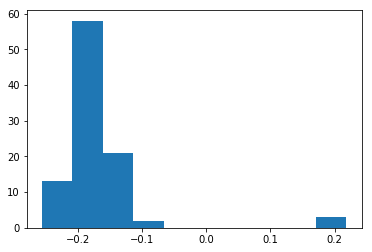

In [8]:
tmp = plt.hist(eff_vec_test)

In [9]:
# Who are the negative connections
q = fdr_test < 0.05
eff_test = eff_mat * q
for i, j in np.argwhere(eff_test<0):
    n_i = label[label.roi==i+1].name.values[0]
    n_j = label[label.roi==j+1].name.values[0]
    print('N between  ||| {} ----- {}'.format(n_i, n_j))

N between  ||| CAUDATE_NUCLEUS_HEAD_and_NUCLEUS_ACCUMBENS ----- ANTERIOR_CINGULATE_CORTEX_dorsal
N between  ||| TEMPORAL_POLE ----- CEREBELLUM_VIIIab
N between  ||| TEMPORAL_POLE ----- ANTERIOR_CINGULATE_CORTEX_dorsal
N between  ||| DORSOMEDIAL_PREFRONTAL_CORTEX_posterior ----- TEMPORAL_POLE
N between  ||| CEREBELLUM_CRUSII_right ----- TEMPORAL_POLE
N between  ||| POSTERIOR_INSULA_dorsal ----- CAUDATE_NUCLEUS_HEAD_and_NUCLEUS_ACCUMBENS
N between  ||| left_INFERIOR_PARIETAL_LOBULE ----- DORSOMEDIAL_PREFRONTAL_CORTEX_posterior
N between  ||| POSTERIOR_CINGULATE_CORTEX_dorsal ----- CAUDATE_NUCLEUS_HEAD_and_NUCLEUS_ACCUMBENS
N between  ||| INFERIOR_TEMPORAL_GYRUS ----- CEREBELLUM_CRUSII_right
N between  ||| MIDDLE_TEMPORAL_GYRUS_anterior ----- DORSOMEDIAL_PREFRONTAL_CORTEX_posterior
N between  ||| AMYGDALA_and_HIPPOCAMPUS ----- ANTERIOR_CINGULATE_CORTEX_dorsal
N between  ||| AMYGDALA_and_HIPPOCAMPUS ----- CAUDATE_NUCLEUS_HEAD_and_NUCLEUS_ACCUMBENS
N between  ||| CEREBELLUM_VI ----- TEMPORA

In [10]:
# Compute the percent discovery
p_disc = np.array([np.sum(fdr[:, i] < 0.05) / 64 for i in range(64)])
# Sort it and then revert the order so they go from big to small
ind = np.argsort(p_disc)[::-1]
# Compute the percent of significant connections as a function of the number of
# regions
fdr_mask = np.copy(fdr)
fdr_mask[np.tril(np.ones((64,64)).astype(bool),-1)] = 1
total_sig = np.sum(fdr[np.triu(np.ones((64,64)).astype(bool))]<0.05)
perc_top = np.zeros(64)
perc_joint = np.zeros(64)
for i in range(64):
    top_mask = np.zeros_like(fdr).astype(bool)
    joint_mask = np.zeros_like(fdr).astype(bool)
    top_mask[ind[:i+1], :] = True
    top_mask[:, ind[:i+1]] = True
    joint_mask[np.meshgrid(ind[:i+1], ind[:i+1])] = True
    perc_top[i] = np.sum(fdr_mask[top_mask]<0.05)/total_sig
    perc_joint[i] = np.sum(fdr_mask[joint_mask]<0.05)/total_sig

/home/surchs/conda/envs/svip/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


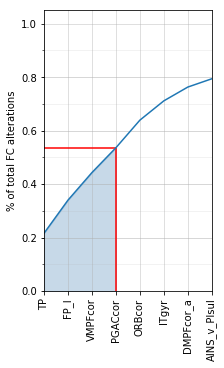

In [11]:
# Show that
n_show = 8
top_x = 4
f = plt.figure(figsize=(3,5), constrained_layout=True)
ax = f.add_subplot(111)
p = ax.plot(range(64), perc_top)
ax.fill_between(np.arange(top_x), 0, perc_top[:top_x], color='steelblue', alpha=0.3)
ax.set_ylim([1, 1.05])
ax.set_yticks(np.arange(0,1,0.1), minor=True)
ax.set_xlim([0, n_show-1])
ax.set_xticks(range(n_show))
ax.vlines(top_x-1, 0, perc_top[top_x-1] , color='red')
ax.hlines(perc_top[top_x-1], 0, top_x-1, color='red')
tmp = ax.set_xticklabels(label.label.values[ind], rotation=90)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
ax.set_ylabel('% of total FC alterations')
f.savefig(os.path.join(fig_p, 'blue_line_narrow.png'), dpi=300, transparent=True)

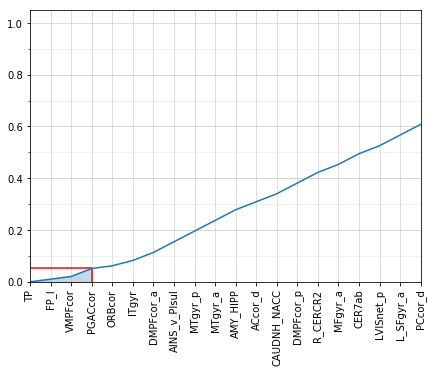

In [12]:
# Show that
n_show = 20
top_x = 4
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(111)
p = ax.plot(range(64), perc_joint)
ax.fill_between(np.arange(top_x), 0, perc_joint[:top_x], color='steelblue', alpha=0.3)
ax.set_ylim([1, 1.05])
ax.set_yticks(np.arange(0,1,0.1), minor=True)
ax.set_xlim([0, n_show-1])
ax.set_xticks(range(n_show))
ax.vlines(top_x-1, 0, perc_joint[top_x-1] , color='red')
ax.hlines(perc_joint[top_x-1], 0, top_x-1, color='red')
tmp = ax.set_xticklabels(label.label.values[ind], rotation=90)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

In [13]:
# Get the top X networks
for i in range(top_x):
    print('({}) {} has {:.3f}% DISC ({})'.format(ind[i]+1, label.name.values[ind[i]], p_disc[ind[i]], int(p_disc[ind[i]]*64)))
# Find the percent of significant connections they account for

print(('\nTogether they account for {:.3f}% of significant connections'
       '\nBetween them they have {:.3f}% of {} significant connections').format(perc_top[top_x-1], perc_joint[top_x-1], total_sig))

(9) TEMPORAL_POLE has 0.328% DISC (21)
(55) FRONTAL_POLE_lateral has 0.203% DISC (13)
(42) VENTRAL_MEDIAL_PREFRONTAL_CORTEX has 0.172% DISC (11)
(34) PERIGENUAL_ANTERIOR_CINGULATE_CORTEX has 0.172% DISC (11)

Together they account for 0.536% of significant connections
Between them they have 0.052% of 97 significant connections


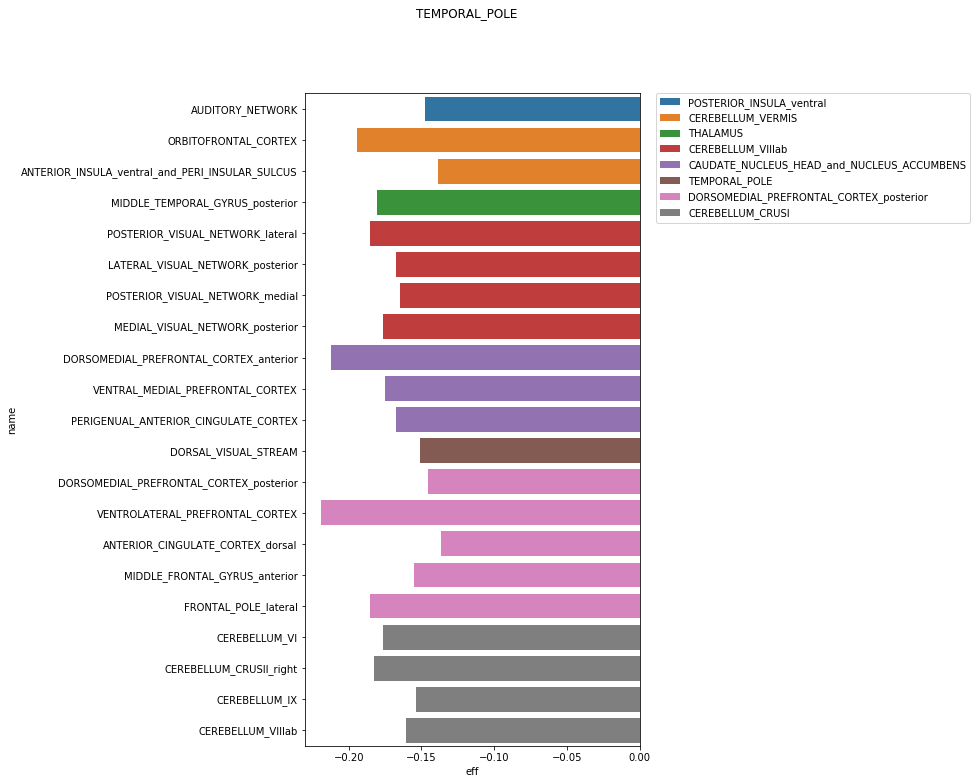

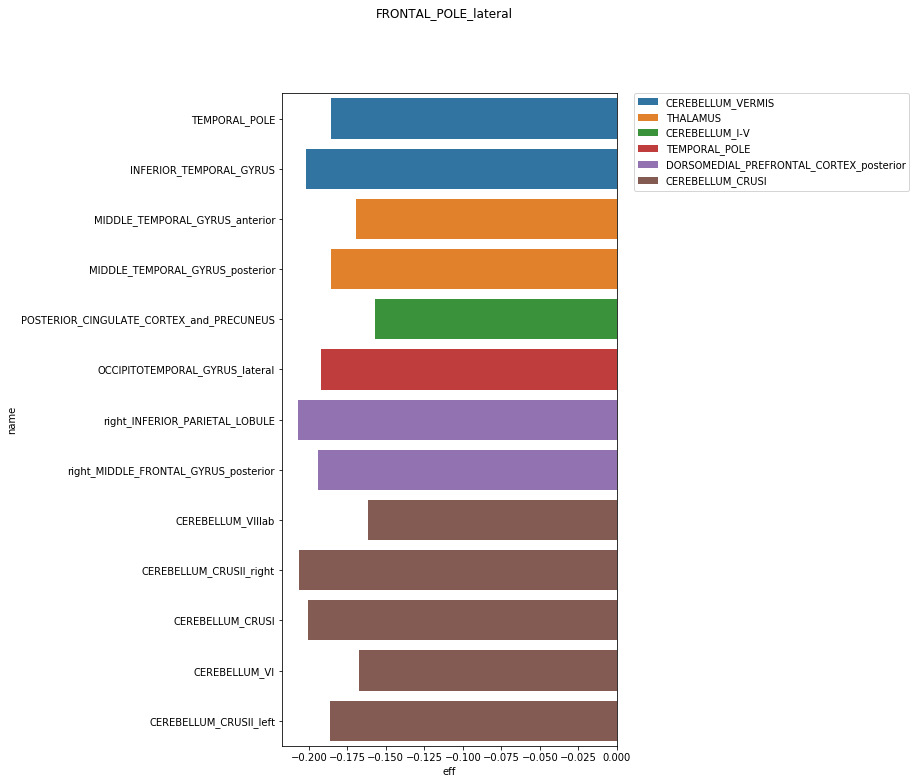

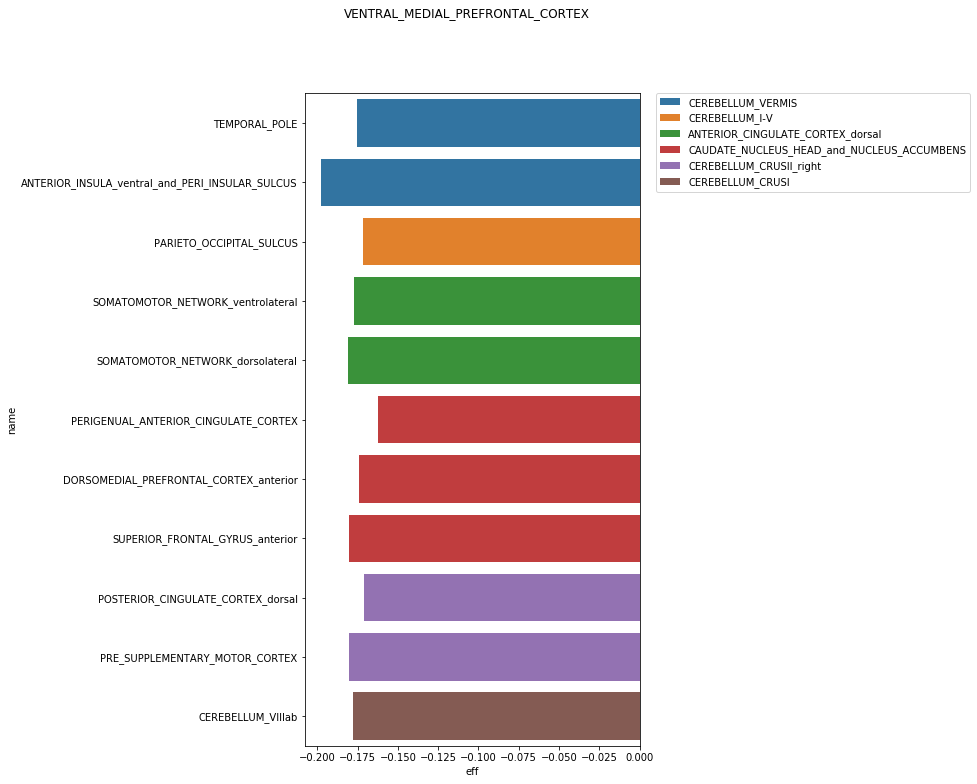

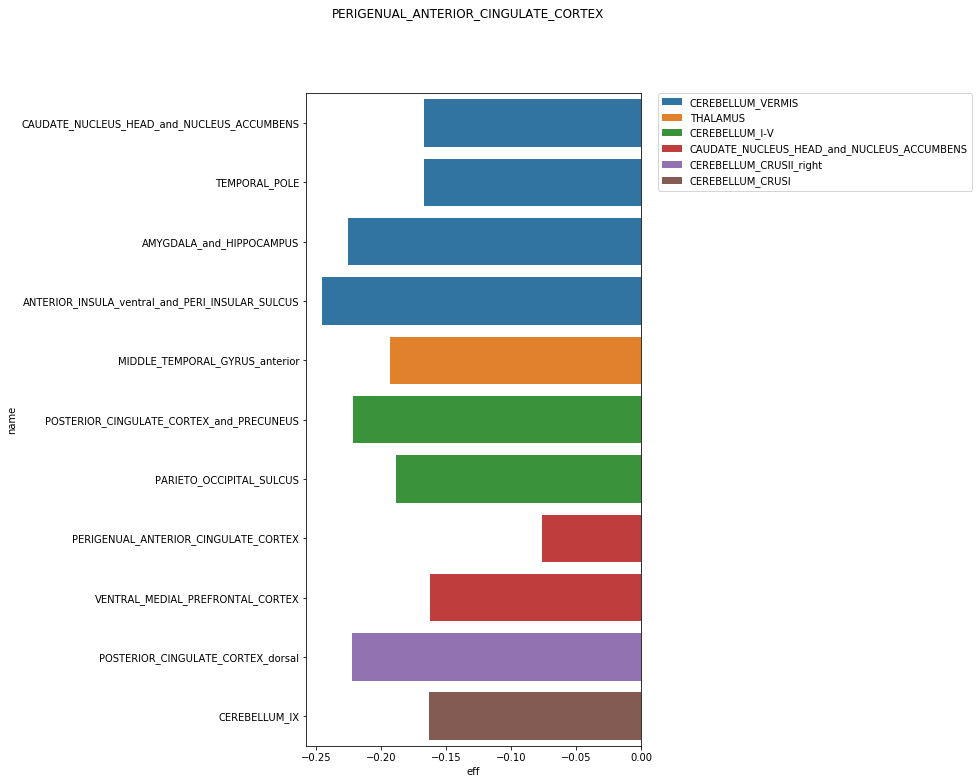

In [14]:
# Show me the connections to other networks please
top_4 = ind[:4]
for i in top_4:
    # Get the altered connections and their effects
    sig_ind = np.argwhere(fdr[i, :]<0.05).flatten()
    # Find the network 7 group
    group = np.array([hier[hier.s64==g+1].s12.values[0] for g in sig_ind])
    group_names = [label12[label12.roi==gr].name.values[0] for gr in group]
    eff_vec = eff_mat[i, sig_ind].flatten()
    conn_names = np.array(list(label.iloc[sig_ind].name.values))
    
    group_ind = np.argsort(group)
    t = label.loc[sig_ind, :]
    t['group'] = group_names
    t['eff'] = eff_vec

    f = plt.figure(figsize=(6,12))
    ax = f.add_subplot(111)
    g = sbn.barplot(x="eff", y="name", hue="group", data=t.iloc[group_ind], ax=ax, dodge=False)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    f.suptitle('{}'.format(label[label.roi==i+1].name.values[0]))

## Threshold the effects
Take the top 20% of connections and do the same thing

In [15]:
eff_vec_thr = eff_vec_full[fdr_vec<0.05]

In [16]:
n_top = int(np.floor(eff_vec_thr.shape[0]*0.2))
print(n_top)

19


In [17]:
# Get the smallest absolute effect size of the top 20%
eff_crit = np.sort(np.abs(eff_vec_thr))[::-1][:n_top][-1]

eff_top_mask = np.abs(eff_mat)>eff_crit
eff_top = np.zeros_like(eff_mat)
eff_top[eff_top_mask] = eff_mat[eff_top_mask]
fdr_top = np.zeros_like(fdr)
fdr_top[eff_top_mask] = fdr[eff_top_mask]

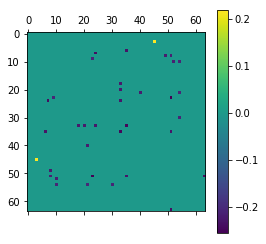

In [18]:
plt.matshow(eff_top)
plt.colorbar()

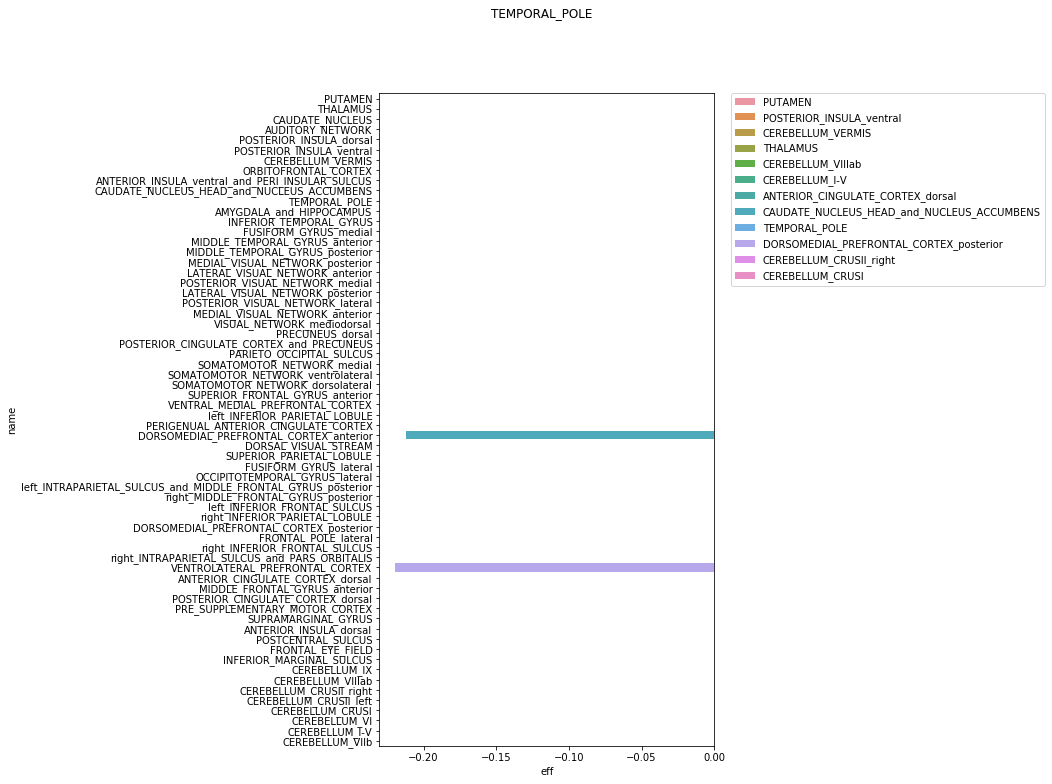

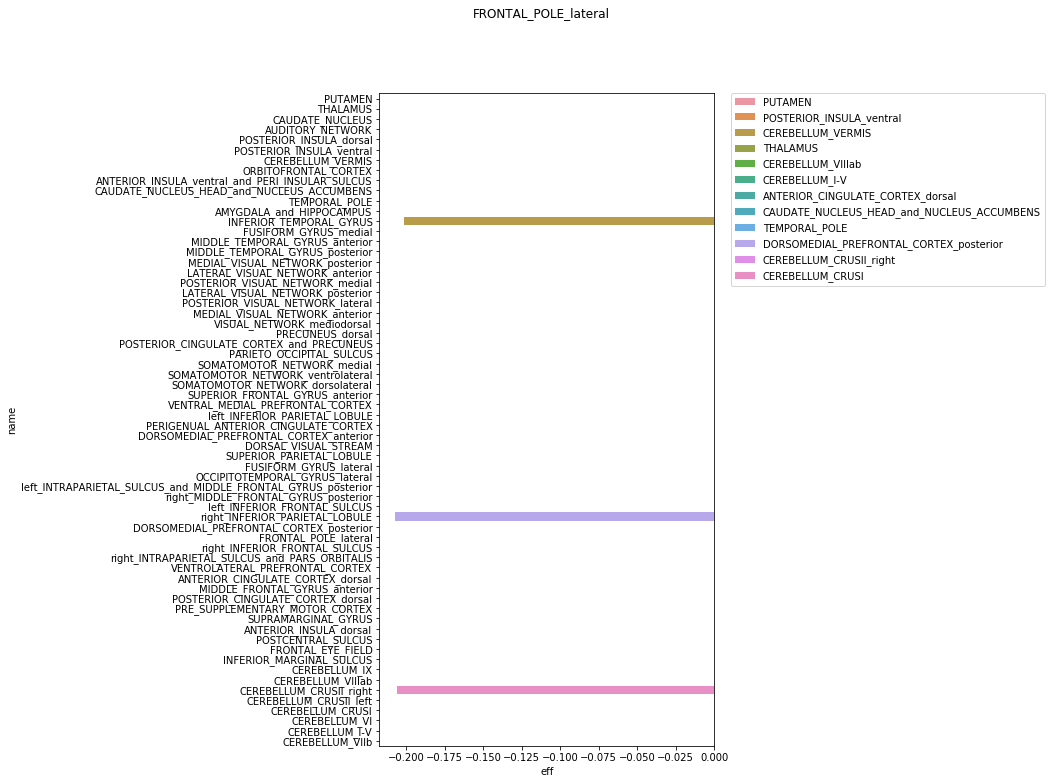

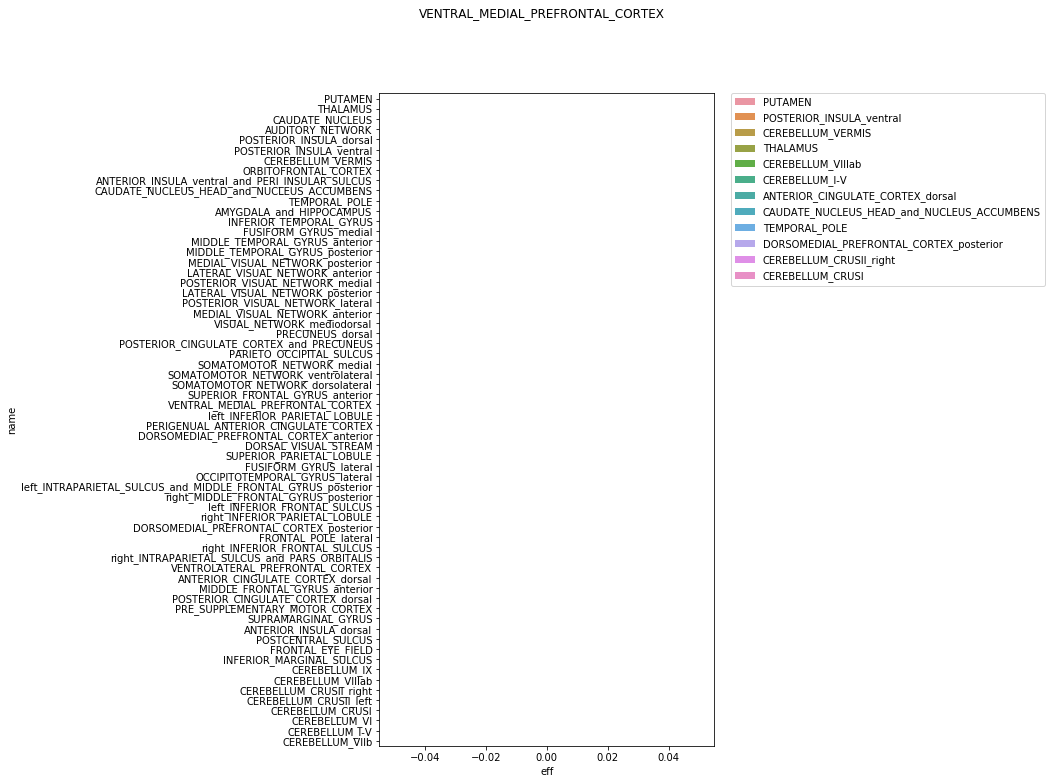

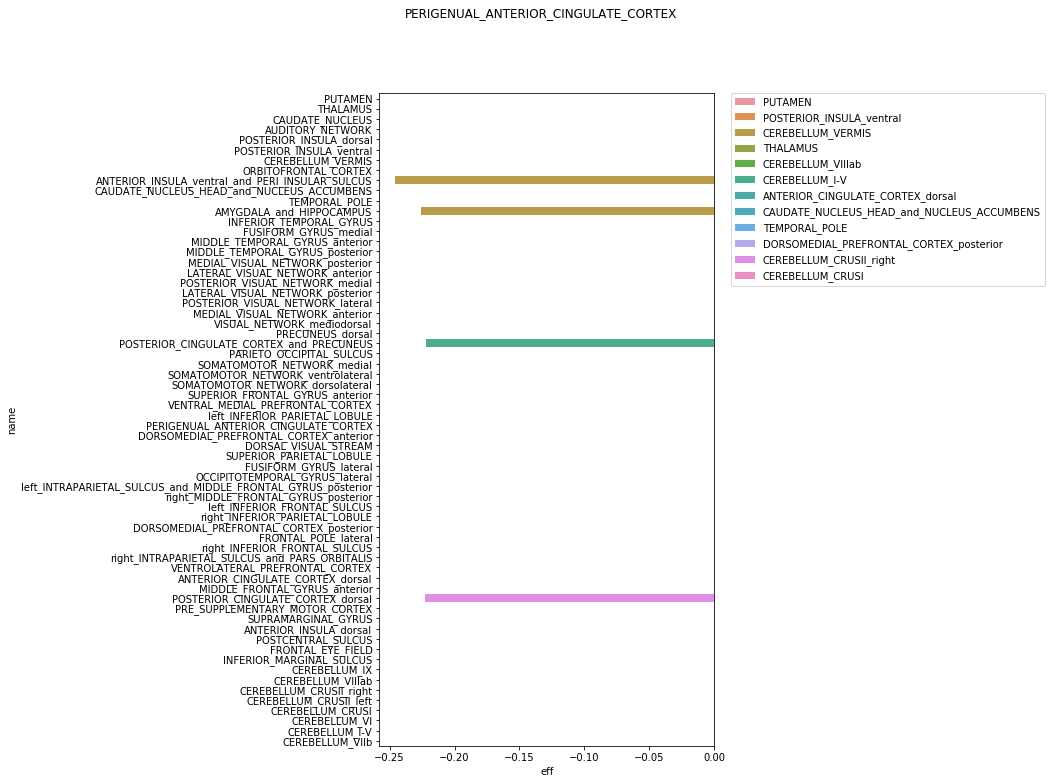

In [19]:
eff_mat = eff_top
fdr = fdr_top
# Show me the connections to other networks please
top_4 = ind[:4]
for i in top_4:
    # Get the altered connections and their effects
    sig_ind = np.argwhere(fdr[i, :]<0.05).flatten()
    # Find the network 7 group
    group = np.array([hier[hier.s64==g+1].s12.values[0] for g in sig_ind])
    group_names = [label12[label12.roi==gr].name.values[0] for gr in group]
    eff_vec = eff_mat[i, sig_ind].flatten()
    conn_names = np.array(list(label.iloc[sig_ind].name.values))
    
    group_ind = np.argsort(group)
    t = label.loc[sig_ind, :]
    t['group'] = group_names
    t['eff'] = eff_vec

    f = plt.figure(figsize=(6,12))
    ax = f.add_subplot(111)
    g = sbn.barplot(x="eff", y="name", hue="group", data=t.iloc[group_ind], ax=ax, dodge=False)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    f.suptitle('{}'.format(label[label.roi==i+1].name.values[0]))